In [1]:
# Testing SVR Model With Microsoft Stock



In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import pandas as pd
import ta
import matplotlib.dates as mdates
from sklearn.svm import SVR
import numpy as np
from sklearn import svm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.svm import SVR
from sklearn.metrics import explained_variance_score, r2_score
import ta
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from src.visualization.visualize import DisplayTicker
from src.features.build_features import BuildFeatures


In [40]:
def convert_data(stock_ticker_csv, start_date, end_date):
    """
    stock_ticker_csv : csv file
    end_date : string
    days_to_backtrack : int
    Takes in a CSV File and converts the date to numbers
    Returns DF with Dates converted to numerical format and the original Dates for plotting
    """

    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    #print(start_date)
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    #print(start_date)
    
    # set the number of days to look back
    #look_back = (end_date+timedelta(-days)).strftime('%Y-%m-%d')

    # Load the CSV File
    stock_ticker = pd.read_csv(stock_ticker_csv, index_col=['Date'], parse_dates=['Date'])
    stock_ticker.sort_values('Date')
    stock_ticker = stock_ticker[start_date: end_date]
    #print(stock_ticker.info())

    stock_ticker.reset_index(inplace=True)
    
    data_df = stock_ticker.copy()
    data_df = data_df.reset_index()
    org_dates = data_df['Date']
    data_df['Pretty Date'] = data_df['Date']
    

    # Converting Dates to Numbers - SVR doesn't work with dates
    data_df['Date'] = data_df['Date'].map(mdates.date2num)
    #print(dates_df['Date'][:5])

    indicator_bb = ta.volatility.BollingerBands(close=data_df["Close"], n=20, ndev=2)
    indicator_SMA20 = ta.trend.SMAIndicator(close=data_df["Close"],n=20, fillna=True)
    indicator_MACD = ta.trend.MACD(close=data_df["Close"],n_fast=5, n_slow=30, fillna=True)
  

    data_df['SMA_20'] = indicator_SMA20.sma_indicator()
    data_df['bb_bbm'] = indicator_bb.bollinger_mavg()
    data_df['bb_bbh'] = indicator_bb.bollinger_hband()
    data_df['bb_bbl'] = indicator_bb.bollinger_lband()
    data_df['MACD'] = indicator_MACD.macd()
    data_df['MACD signal'] = indicator_MACD.macd_signal()

    #print(len(data_df))
    # Return DF with Dates converted to numerical format and the original Dates for plotting
    return data_df, org_dates
start_date = '2019-11-30'
end_date = '2020-01-31'
MSFT, MSFT_dates = convert_data('./.data/MSFT.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AAPL.csv',start_date, end_date)
AAPL, AAPL_dates = convert_data('./.data/AMZN.csv',start_date, end_date)
GOOG, GOOG_dates = convert_data('./.data/GOOG.csv',start_date, end_date)
_GSPC, _GSPC_dates = convert_data('./.data/_GSPC.csv',start_date, end_date)



37   2020-01-27
38   2020-01-28
39   2020-01-29
40   2020-01-30
41   2020-01-31
Name: Date, dtype: datetime64[ns]
Total Days: 47
First Forecast date: 37   2020-01-27
Name: Pretty Date, dtype: datetime64[ns]
Last Forecast date: 41   2020-01-31
Name: Pretty Date, dtype: datetime64[ns]
----------------------------------------
----------------------------------------
----------------------------------------
test_x:         Date      SMA_20        Open
37  737451.0  162.085999  161.149994
38  737452.0  162.410999  163.779999
39  737453.0  162.933498  167.839996
40  737454.0  163.687498  174.050003
41  737455.0  164.167999  172.210007
test_y:          Close
37  162.279999
38  165.460007
39  168.039993
40  172.779999
41  170.229996
(37, 3)
(37, 1)
++++++++++++++++++++++++++++++++++++++++
(5, 3)
(5, 1)


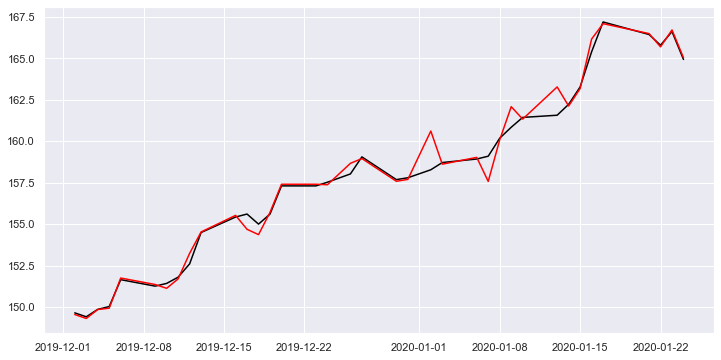

Predicted Values: [164.49929619 164.80134403 162.31449695 157.97552013 159.69360781]
Actual Values: [[162.279999]
 [165.460007]
 [168.039993]
 [172.779999]
 [170.229996]]
Dates: 37   2020-01-27
38   2020-01-28
39   2020-01-29
40   2020-01-30
41   2020-01-31
Name: Pretty Date, dtype: datetime64[ns]
Model Score: -1.9117063298376755


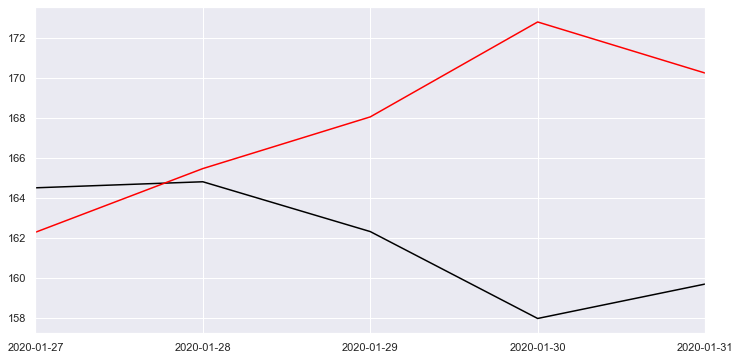

In [41]:
def predict_multiple_variables(ticker_df, dates_org, num_forecast_days):

    num_training_days = len(ticker_df)
    print(dates_org[-num_forecast_days:])
    print("Total Days: {}".format(num_training_days+num_forecast_days))
    print("First Forecast date: {}".format(ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1]))
    print("Last Forecast date: {}".format(ticker_df['Pretty Date'][-1:]))
    #print(ticker_df['Pretty Date'][-1])
    # Separate Training based on the number of training days
    train_x = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Date','SMA_20','Open']]
    # Seperate Predicted variable
    train_y = ticker_df[-(num_training_days+num_forecast_days):-num_forecast_days][['Close']]

    print("-" * 40)
    #print("train_x: {}".format(train_x))
    #print("train_y: {}".format(train_y))
    print("-" * 40)

    # Split off test days for forecasting
    test_x = ticker_df[-num_forecast_days:][['Date', 'SMA_20','Open']]
    test_y = ticker_df[-num_forecast_days:][['Close']]
    
    print("-" * 40)
    print("test_x: {}".format(test_x))
    print("test_y: {}".format(test_y))
    print(train_x.shape)
    print(train_y.shape)
    print("+" * 40)
    
    print(test_x.shape)
    print(test_y.shape)
    
    # Fit training data using SVR/RBF
    svr_rbf = SVR(kernel= 'rbf', C= 1000, gamma= .009)
    #svr_rbf.fit(train_dates[-DF_Train_Index:], train_prices[-DF_Train_Index:])
    svr_rbf.fit(train_x, train_y)


    

    plt.figure(figsize = (12,6))
    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        svr_rbf.predict(train_x), 
                        color= 'black', label= 'Train Data')

    plt.plot(ticker_df['Pretty Date'][-(num_training_days+num_forecast_days):-num_forecast_days], 
                        train_y , 
                        color= 'red', 
                        label= 'Train Data Actual')
    plt.show()
    
    y_pred = svr_rbf.predict(test_x)

    print("Predicted Values: {}".format(y_pred))
    print("Actual Values: {}".format(test_y.to_numpy()))
    print("Dates: {}".format(ticker_df['Pretty Date'][-num_forecast_days:]))
    # Show explained variance 
    model_score = explained_variance_score(y_true=test_y, y_pred=y_pred)
    print("Model Score: {}".format(model_score))
    
    plt.figure(figsize = (12,6))

    ax = plt.gca()
    formatter = mdates.DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(formatter)
    locator = mdates.DayLocator()
    ax.xaxis.set_major_locator(locator)
    
    #print("xmin: {}".format(num_forecast_days:num_forecast_days+1 ))
    if num_forecast_days == 1:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:], xmax=ticker_df['Pretty Date'][-1:])
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'black', 
                        label= 'Test Data')
        plt.scatter(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'red', 
                        label= 'Actual')
    else:
        plt.xlim(xmin=ticker_df['Pretty Date'][-num_forecast_days:-num_forecast_days+1], xmax=ticker_df['Pretty Date'][-1:])
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], svr_rbf.predict(test_x), 
                        color= 'black', 
                        label= 'Test Data')
        plt.plot(ticker_df['Pretty Date'][-num_forecast_days:], test_y, 
                        color= 'red', 
                        label= 'Actual')
    
    #print("X max: {}, X Min: {}".format(xmax, xmin))
    plt.show()

    

predict_multiple_variables(MSFT,MSFT_dates,5)